<center>
    COMP4600/5500 - Reinforcement Learning

# Homework 6 - On-policy Control with Approximation

### Due: Monday, November 15th 11:59 pm
    
</center>

Student Name: ______________________ 

The purpose of this project is to study different properties of Function Approximation with on-policy control methods.  

In [1]:
# You are allowed to use the following modules
import numpy as np
import matplotlib.pyplot as plt
from mountain_car import MountainCar
import pygame as pg
from itertools import product, count
from collections import deque


pygame 2.0.1 (SDL 2.0.14, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Task description
Consider the task of driving an underpowered car up a steep mountain road, as suggested by the diagram in the upper left of the following figure. The difficulty is that gravity is stronger than the car's engine, and even at full throttle the car cannot accelerate up the steep slope. The only solution is to first move away from the goal and up the opposite slope on the left. Then by applying full throttle the car can build up enough inertia to carry it up the steep slope even though it is slowing down the whole way.


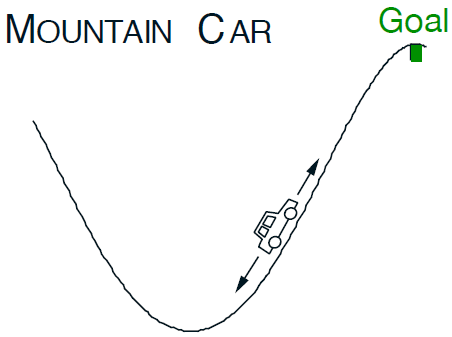


This is a continuous control task where things have to get worse in a sense (farther from the goal) before they can get better. The reward in this problem is -1 on all time steps until the car moves past its goal position at the top of the mountain, which ends the episode. There are three possible actions: full throttle forward (+1), full throttle reverse (-1), and zero throttle (0). The car moves according to a simplified physics. Its position $x_t$ and velocity $\dot{x}_t$ are updated by

$x_{t+1} \doteq \text{bound}[x_t + \dot{x}_{t+1}]$

$\dot{x}_{t+1} \doteq \text{bound}[\dot{x}_t + 0.001 A_t - 0.0025 \cos(3x_t)]$


where the \textit{bound} operation enforces $-1.2 \le x_{t+1} \le 0.5$ and $-0.07 \le \dot{x}_{t+1} \le 0.07$. In addition, when $x_{t+1}$ reached the left bound, $\dot{x}_{t+1}$ was reset to zero. When it reached the right bound, the goal was reached and the episode was terminated. Each episode starts from a random position $x_t \in [-0.6, -0.4)$ and zero velocity.


## Part I

You have been given a simple implementation of the Mountain Car task. 

1. Your first task is to check and confirm that the given code simulates the above formulae and task description. Then write a function that generates random episodes for this task. You should use the given code for the Mountain Car task. 


In [2]:
def episode():
    car = MountainCar()
    x = np.random.uniform(-0.6, -0.4)
    v = 0
    X = [x]
    while True:
        a = np.random.choice(car.actions)
        x, v, r, goal_reached = car.move(x, v, a)
        X.append(x)
        if goal_reached:
            return X
        

2. Use the Pygame library to develop a simple function that animates a given episode/trajectory. The equation for the mountain is $y = 0.45\sin(3x) + 0.55$. Use a randomly generated episode from the function you developed above and pass it to your animation function, then plot the results.

In [4]:
FPS = 40
BG_COLOR = pg.Color(200, 200, 200)
CURVE_COLOR = pg.Color(70, 70, 70)
CAR_COLOR = pg.Color(200, 70, 70)

SCALE = 1000
PAD = 200

X_MIN, X_MAX = -1.2, 0.5
Y_MAX, Y_MIN = 1, 0

WIDTH = int((X_MAX - X_MIN) * SCALE  + PAD)
HEIGHT = int((Y_MAX - Y_MIN) * SCALE  + PAD)

def transform(x, y):
    """transform an xy coordinate to pygame screen coordinates"""
    return (x + 1.2) * SCALE + PAD / 2, (1 - y) * SCALE + PAD / 2

def curve(x):
    return 0.45 * np.sin(3*x) + 0.55


class PgCar:

    def __init__(self):
        self.screen, self.bg = self.init()
        
    def init(self):
        pg.init()  # initialize pygame
        screen = pg.display.set_mode((WIDTH, HEIGHT))  # set up the screen
        pg.display.set_caption("Mohamed Martini")  # add a caption
        bg = pg.Surface(screen.get_size())  # get a background surface
        bg = bg.convert()
        bg.fill(BG_COLOR)
        screen.blit(bg, (0, 0))
        return screen, bg

    def draw_curve(self):
        start = None
        for x in np.arange(X_MIN, X_MAX, 0.001):
            end = transform(x, curve(x))
            try:
                pg.draw.line(self.screen, CURVE_COLOR, start, end, width=7)
            except:
                continue
            finally:
                start = end

    def render(self):
        """show the grid array on the screen"""
        pg.display.flip()
        pg.display.update()
    
    def reset_screen(self):
        self.screen.fill(BG_COLOR)
        self.draw_curve()
    
    def animate(self, X):
        """receive a list of positions on the x axis, and plot the movement of the screen"""
        clock = pg.time.Clock()
        radius = 20
        i = 0
        num_steps = len(X)
        run = True
        while run:
            clock.tick(FPS)
            for event in pg.event.get():
                if event.type == pg.QUIT:
                    run = False
            if i == num_steps - 1:
                continue
            i += 1
            center = transform(X[i], curve(X[i]))
            self.reset_screen()
            pg.draw.circle(self.screen, CAR_COLOR, center, radius, width=radius)
            self.render()
        pg.quit()
        

X = episode()      
PgCar().animate(X)

## Part II

Develop a function approximation procedure based on either **Polynomials** or **Fourier basis** (recommended). Given the current $\bar{w}$, the developed function approximation method should return the value for each specific state.

In [8]:
def fourier_basis(s_: np.array, d: int):
    k = s_.shape[0]
    num_features = (d + 1) ** k
    x_ = np.zeros(num_features)
    for i, c in enumerate(product(range(d + 1), repeat=k)):
        c_ = np.array(c)
        x_[i] = np.cos(np.pi * s_.T @ c_)
    return x_


def q(W_, x_):
    """get all actions values for a given state (encoded in x_)"""
    q_ = np.zeros(W_.shape[0])
    for i in range(W_.shape[0]):
        q_[i] = W_[i].T @ x_
    return q_


def my_argmax(array):
    """
    return argmax and break ties
    """
    max_ = np.max(array)
    indx = [i for i in range(len(array)) if array[i] == max_]
    return np.random.choice(indx)

def e_greedy(array, eps):
    if np.random.choice((True, False), p=(1 - eps, eps)):
        return my_argmax(array)
    return np.random.choice(range(array.shape[0]))


## Part III (COMP4600)

1. Implement the **Episodic Semi-gradient SARSA** (pp. 244).

In [22]:
shift = np.array((1.2, 0.07))
scale = np.array((1.7, 0.14))

def xv_to_s(xv):
    """transform from xv to normalized state"""
    return (xv + shift) / scale

def s_to_xv(s):
    """transform from normalized state to xv"""
    return s * scale - shift

def SARSA_0(d: int, num_episodes):
    car = MountainCar()
    A_ = np.array(car.actions)
    alpha = 1e-3
    eps = 0.5
    gamma = 1
    k = 2
    W_ = np.zeros((A_.shape[0], (d + 1) ** k))  # w for each action
    steps_per_e = np.zeros(num_episodes)
    

    for episode in range(num_episodes):
        eps = 1 / (episode + 1)
        # save positions here for each episode
        X = []
        
        # choose random initial position, and set initial v to 0
        xv = np.array((np.random.uniform(-0.6, -0.4), 0))
        s_ = xv_to_s(xv)

        # get the fourier basis for the given state, with order n
        # get the values of all actions at this state
        # choose the best action - e-greedy
        x_ = fourier_basis(s_, d)
        q_ = q(W_, x_)
        a = e_greedy(q_, eps)
        
        # go through episode
        for step in count():

            # take action, observe r and sp
            x, v = s_to_xv(s_)
            xp, vp, r, goal_reached = car.move(x, v, A_[a])
            s_p_ = xv_to_s(np.array((xp, vp)))
            
            X.append(xp)

            # if terminal state is reached, update the weights and start next episode 
            if goal_reached: # or step == 10000:
                W_[a] += alpha * (r - q_[a]) * x_
                car.goal_reached = False
                break

            
            # get the fourier basis of next state
            # get actions values from next state
            # choose the best action - e-greedy
            x_p_ = fourier_basis(s_p_, d)
            q_p_ = q(W_, x_p_)
            a_p = e_greedy(q_p_, eps)
            
            # update the weights, and make next state/action current state/action
#             print(W_[a])
            W_[a] += alpha * (r + gamma * q_p_[a_p] - q_[a]) * x_
            s_ = s_p_
            a = a_p
        steps_per_e[episode] = step
    return W_, X, steps_per_e


2. Use the algorithm to learn the Mountain Car task. Tune the step-size parameter ($\alpha$), select a proper Function Approximation order, discount factor ($\gamma$), exploration probability ($\varepsilon$). Plot step-per-episode (in log scale) vs. number of episodes. This plot should be averaged over 50-100 runs.    

In [23]:
runs = 1
num_episodes = 10

steps_per_e_per_run = np.zeros((runs, num_episodes))
for run in range(runs):
    W_, X, steps_per_e = SARSA_0(d=3, num_episodes=num_episodes)
    steps_per_e_per_run[run, :] = np.copy(steps_per_e)

plt.figure(figsize=(10, 10))
plt.plot(np.log10(steps_per_e_per_run.mean(0)))

<ipython-input-8-27fa83293fc1>:15: RuntimeWarning: overflow encountered in matmul
  q_[i] = W_[i].T @ x_
<ipython-input-8-27fa83293fc1>:15: RuntimeWarning: invalid value encountered in matmul
  q_[i] = W_[i].T @ x_


ValueError: 'a' cannot be empty unless no samples are taken

3. Show an animation of the task.

In [ ]:
PgCar().animate(X)

## Part III (COMP5500)

1. Implement the **Episodic Semi-gradient $n$-step SARSA** (pp. 247).

In [12]:
def SemiGradientNStepSarsa(d, n, num_episodes):
    car = MountainCar()
    A_ = np.array(car.actions)
    alpha = 0.01
    eps = 0.1
    gamma = 1
    k = 2
    W_ = np.zeros((A_.shape[0], (d + 1) ** k))  # w for each action
    steps_per_e = np.zeros(num_episodes)
    
    for episode in range(num_episodes):
        S = deque([], maxlen=n+1)
        A = deque([], maxlen=n+1)
        R = deque([0], maxlen=n+1)

        # save positions here for each episode
        X = []
        
        # initialize and store S0
        xv = np.array((np.random.uniform(-0.6, -0.4), 0))
        s0_ = xv_to_s(xv)
        S.append(s0_)
        
        # select and store A0
        x_ = fourier_basis(s0_, d)
        q_ = q(W_, x_)
        a0 = e_greedy(q_, eps)
        A.append(a0)
        
        
        T = np.inf
        for t in count():
            if t < T:
                # take action At from state St
                a = A[t % (n + 1)]
                x, v = s_to_xv(S[t % (n + 1)])
                xp, vp, r, goal_reached = car.move(x, v, A_[a])
                X.append(xp)
                
                # observe and store the next state and next reward
                s_p_ = xv_to_s(np.array((xp, vp)))
                S.append(s_p_)
                R.append(r)
                
                if goal_reached:
                    T = t + 1
                    car.goal_reached = False
                else:
                    # select and store At+1
                    x_p_ = fourier_basis(S[(t + 1) % (n + 1)], d)
                    q_p_ = q(W_, x_p_)
                    a_p = e_greedy(q_p_, eps)
                    A.append(a_p)
                 
            tau = t - n + 1
            if tau >= 0:
                G = 0
                for i in range(tau + 1, min(tau + n, T) + 1):
                    G += R[i % (n+1)] * gamma ** (i - tau - 1)
                    
                if tau + n < T:
                    x_ = fourier_basis(S[(tau + n) % (n + 1)], d)
                    q_val = q(W_, x_)[A[(tau + n) % (n + 1)]]
                    G += q_val * gamma ** n

                x_ = fourier_basis(S[tau % (n + 1)], d)
                q_val = q(W_, x_)[A[tau % (n + 1)]]
                W_[A[tau % (n + 1)]] += alpha * (G - q_val) * x_
                
            if tau == T - 1:
                break
        steps_per_e[episode] = t
    return W_, X, steps_per_e


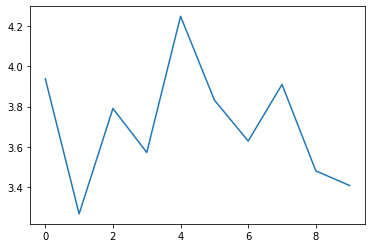

In [14]:
W, X, steps_per_e = SemiGradientNStepSarsa(d=3, n=8, num_episodes=10)
# PgCar().animate(X)
plt.plot(np.log10(steps_per_e))

In [198]:
PgCar().animate(X)

2. Use the algorithm to learn the Mountain Car task with $n \in \{1, 8, 16\}$. Tune the step-size parameter ($\alpha$), select a proper Function Approximation order, discount factor ($\gamma$), exploration probability ($\varepsilon$). Plot step-per-episode (in log scale) vs. number of episodes. This plot should be averaged over 50-100 runs.    

In [ ]:
# Your code here

3. Show an animation of the task for each $n$.

In [ ]:
# Your code here

4. Which value of $n$ results in faster learning? Why?

>Answer 